In [1]:
# Instalamos las librerías necesaris

!pip install statsbombpy
!pip install mplsoccer
!pip install --upgrade mplsoccer

In [2]:
# Librerias utilizadas en los codigos

from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, FancyArrowPatch
from collections import Counter
import textwrap
import os
import base64
import requests
from io import BytesIO
from dotenv import load_dotenv
from IPython.display import Image, display
from matplotlib.cm import get_cmap
from textwrap import fill
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.image as mpimg
import seaborn as sns

In [3]:
# Importamos los datos de los partidos del Bayern Leverkusen desde Statsbomb

events_df = sb.competition_events(
country="Germany",
division="1. Bundesliga",
season="2023/2024",
gender="male")

frames_df = sb.competition_frames(
country="Germany",
division="1. Bundesliga",
season="2023/2024",
gender="male")

frames_df.rename(columns={'event_uuid': 'id'}, inplace = True)

#creamos un diccionario para los datos de statsbomb360
# Diccionario para almacenar freeze_frames por id
freeze_frame = defaultdict(list)
visible_area_dict = {}

# Recorremos cada fila
for _, row in frames_df.iterrows():
    id_valor = row['id']
    
    # Guardar visible_area solo una vez por id
    if id_valor not in visible_area_dict:
        visible_area_dict[id_valor] = row['visible_area']
    
    # Convertir a diccionario y eliminar variables únicas
    fila_dict = row.drop(labels=['id', 'visible_area', 'match_id']).to_dict()
    
    # Añadir al freeze_frame agrupado por id
    freeze_frame[id_valor].append(fila_dict)

# Crear el DataFrame final
frames_df = pd.DataFrame({
    'id': list(freeze_frame.keys()),
    'visible_area': [visible_area_dict[i] for i in freeze_frame.keys()],
    'freeze_frame': [freeze_frame[i] for i in freeze_frame.keys()]
})

# unimos ambas tablas

df = pd.merge(left=events_df, right=frames_df, left_on="id", right_on="id", how="left")

In [4]:
# Carpeta de salida
output_path = Path("../data") / "database_v1.csv"
df.to_csv(output_path, index=False)

In [5]:
# Cargar los archivos necesarios
input_path = Path("../data") / "MatchInfo.csv"
matchinfo_df = pd.read_csv(input_path, low_memory=False)

# Realizar merge posterior con matchinfo
df = pd.merge(left=df, right=matchinfo_df, left_on="match_id", right_on="match_id", how="left")

In [6]:
# Carpeta de salida
output_path = Path("../data") / "database_v2.csv"
df.to_csv(output_path, index=False)

ANALISIS EXPLORATORIO

In [8]:
# Verificar que estén presentes las columnas clave
columnas_necesarias = ['id', 'match_id', 'timestamp', 'location']
columnas_faltantes = [col for col in columnas_necesarias if col not in df.columns]

if columnas_faltantes:
    print("FALTAN columnas clave:", columnas_faltantes)
else:
    print("Todas las columnas clave están presentes.")

# Comprobar si hay valores nulos en las columnas clave
for col in columnas_necesarias:
    nulos = df[col].isnull().sum()
    print(f"{col}: {nulos} valores nulos")

# Validar que la columna 'location' tenga coordenadas válidas
def es_coordenada_valida(x):
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        return isinstance(x, list) and len(x) == 2 and all(isinstance(c, (int, float)) for c in x)
    except:
        return False

df['location_valida'] = df['location'].apply(es_coordenada_valida)
coordenadas_invalidas = (~df['location_valida']).sum()
print(f"Coordenadas inválidas en 'location': {coordenadas_invalidas}")

# Verificar integridad relacional básica (duplicados en ID y match_id)
duplicados_id = df['id'].duplicated().sum()
duplicados_match_id = df['match_id'].duplicated().sum()

print(f"IDs duplicados: {duplicados_id}")
print(f"match_id duplicados: {duplicados_match_id}")

# Mostrar ejemplos de coordenadas inválidas si existen
if coordenadas_invalidas > 0:
    print("\nEjemplos de coordenadas no válidas:")
    print(df[~df['location_valida']][['id', 'location']].head())

Todas las columnas clave están presentes.
id: 0 valores nulos
match_id: 0 valores nulos
timestamp: 0 valores nulos
location: 962 valores nulos
Coordenadas inválidas en 'location': 962
IDs duplicados: 0
match_id duplicados: 137731

Ejemplos de coordenadas no válidas:
                                     id location
0  794ec549-5288-4d1a-93e8-0fc6d3968784      NaN
1  3a9a2c57-b177-47ed-9447-11f081b0e388      NaN
2  49e1fcf3-3fd7-4c72-8d6f-95645e354925      NaN
3  f529205f-e074-44c5-b007-54a56b47b281      NaN
4  c22f124a-cbfb-441e-8f42-3818990f879f      NaN


In [9]:
# Filtrar filas con location nula
nulos_location = df[df['location'].isnull()]

# Ver cuántos tipos de eventos distintos hay
print(nulos_location['type'].value_counts(dropna=False).head(10))

# Ver algunas filas concretas
print(nulos_location[['id', 'match_id', 'type', 'timestamp']].head(10))

type
Substitution       301
Half Start         136
Half End           136
Tactical Shift     127
Injury Stoppage    106
Starting XI         68
Bad Behaviour       34
Player Off          27
Player On           27
Name: count, dtype: int64
                                     id  match_id         type     timestamp
0  794ec549-5288-4d1a-93e8-0fc6d3968784   3895302  Starting XI  00:00:00.000
1  3a9a2c57-b177-47ed-9447-11f081b0e388   3895302  Starting XI  00:00:00.000
2  49e1fcf3-3fd7-4c72-8d6f-95645e354925   3895292  Starting XI  00:00:00.000
3  f529205f-e074-44c5-b007-54a56b47b281   3895292  Starting XI  00:00:00.000
4  c22f124a-cbfb-441e-8f42-3818990f879f   3895333  Starting XI  00:00:00.000
5  f0dd7cfd-6912-4d11-b095-eda30045a7e9   3895333  Starting XI  00:00:00.000
6  26d75901-07fd-4216-906b-2f957b8d871f   3895340  Starting XI  00:00:00.000
7  5fba9d87-5118-4fc1-bc3b-c77ccbbdc9d2   3895340  Starting XI  00:00:00.000
8  33cd60a0-9a6a-4887-945b-bae8ca283c9e   3895348  Starting XI  00:00

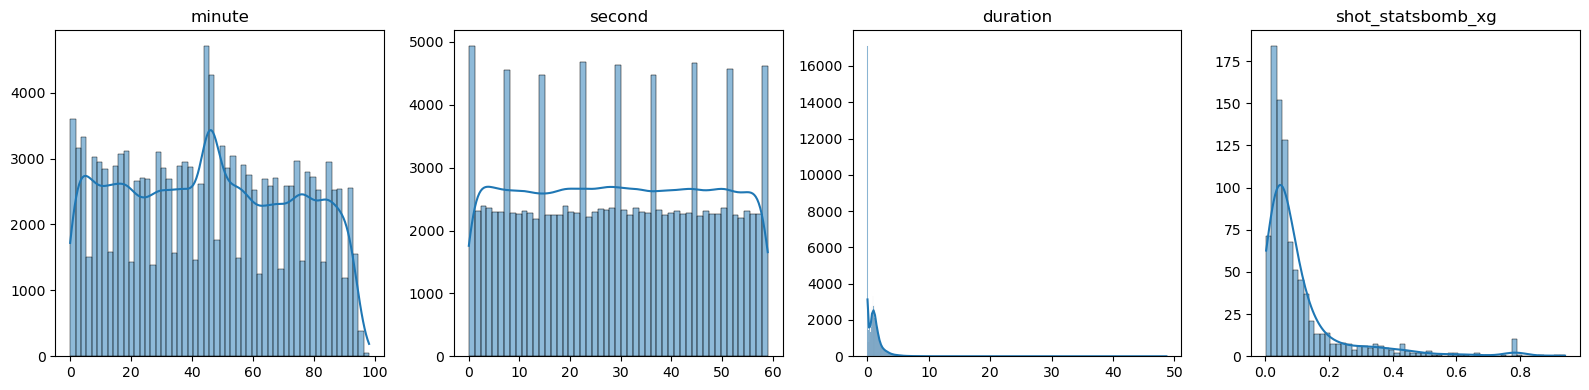

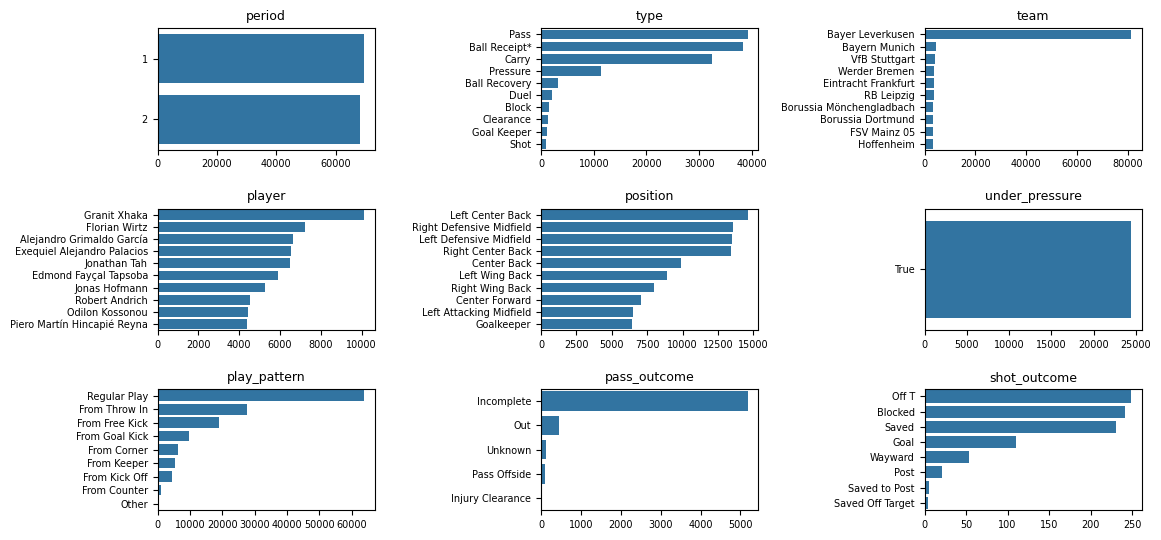

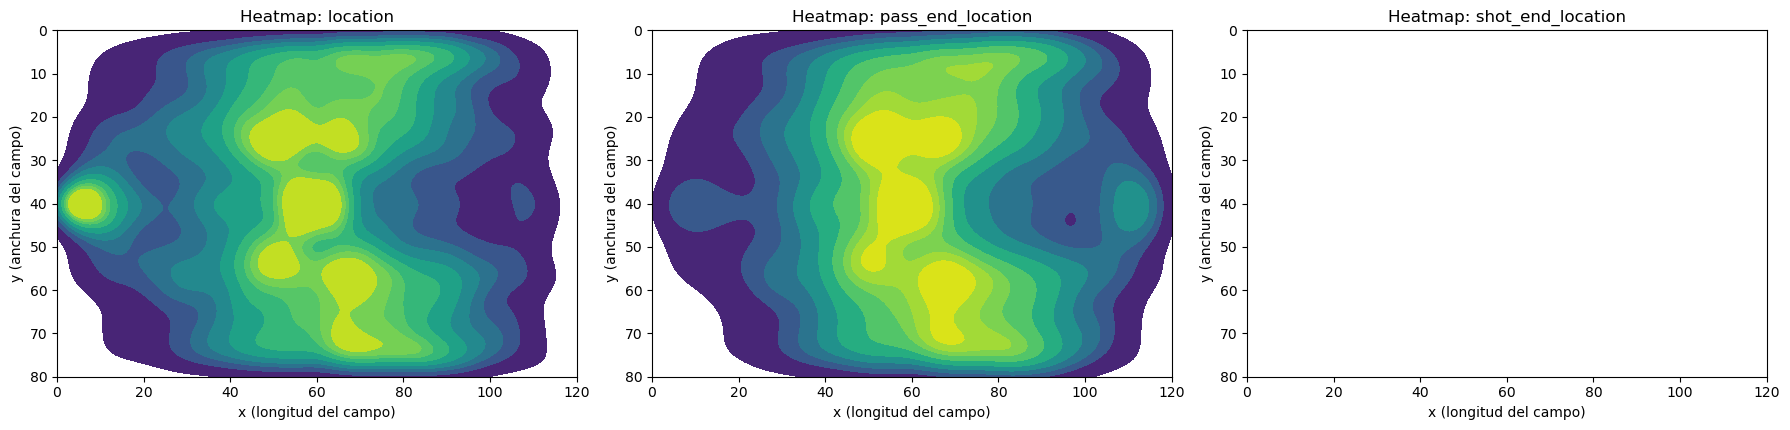

In [38]:
# Variables a analizar
variables = {
    'id': 'id',
    'index': 'index',
    'period': 'period',
    'timestamp': 'timestamp',
    'minute': 'minute',
    'second': 'second',
    'type_name': 'type',
    'team_name': 'team',
    'player_name': 'player',
    'position_name': 'position',
    'location': 'location',
    'duration': 'duration',
    'under_pressure': 'under_pressure',
    'play_pattern': 'play_pattern',
    'pass_end_location': 'pass_end_location',
    'pass_outcome': 'pass_outcome',
    'shot_end_location': 'shot_end_location',
    'shot_statsbomb_xg': 'shot_statsbomb_xg',
    'shot_outcome': 'shot_outcome',
    'freeze_frame': 'freeze_frame',
    'visible_area': 'visible_area'
}

# Gráficos de variables numéricas
num_vars = ['minute', 'second', 'duration', 'shot_statsbomb_xg']
fig, axes = plt.subplots(1, len(num_vars), figsize=(16, 4))
for i, col in enumerate(num_vars):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.tight_layout()
output_dir = Path("../figs/analisis_exploratorio")
output_dir.mkdir(exist_ok=True)  # crea la carpeta si no existe
plt.savefig(output_dir / "var_num.png", dpi=300, bbox_inches="tight")

# Conteo para categóricas
categorical_vars = [
    'period', 'type', 'team', 'player', 'position',
    'under_pressure', 'play_pattern', 'pass_outcome', 'shot_outcome'
]
categorical_vars = [col for col in categorical_vars if col in df.columns]

# Grid compacto para media página: máximo 11.7 x 5.5 pulgadas
n = len(categorical_vars)
ncols = 3
nrows = (n + ncols - 1) // ncols  # Redondeo hacia arriba

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11.7, 5.5))  # A4 media página horizontal
axes = axes.flatten()

# Crear gráficos
for i, col in enumerate(categorical_vars):
    top_values = df[col].value_counts().nlargest(10).index
    sns.countplot(data=df[df[col].isin(top_values)], y=col, order=top_values, ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=9)
    axes[i].tick_params(axis='both', labelsize=7)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Ocultar ejes vacíos
for j in range(len(categorical_vars), len(axes)):
    axes[j].axis('off')

plt.tight_layout(h_pad=1.5)

# Exportar como imagen JPG en alta resolución (300 dpi recomendado)
output_dir = Path("../figs/analisis_exploratorio")
output_dir.mkdir(exist_ok=True)  # crea la carpeta si no existe
plt.savefig(output_dir / "var_cat.png", dpi=300, bbox_inches="tight")

# Visualización espacial: location, pass_end_location, shot_end_location

# Extraer coordenadas
def extraer_coordenadas(df, columna):
    df = df.copy()
    df[columna] = df[columna].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
    df[f'{columna}_x'] = df[columna].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 2 else None)
    df[f'{columna}_y'] = df[columna].apply(lambda x: x[1] if isinstance(x, list) and len(x) == 2 else None)
    return df

# Variables espaciales
espaciales = ['location', 'pass_end_location', 'shot_end_location']
df_clean = df.copy()

for col in espaciales:
    if col in df.columns:
        df_clean = extraer_coordenadas(df_clean, col)

# Crear grid 1x3
import matplotlib.pyplot as plt
import seaborn as sns

# Crear grid 1x3
# Crear grid 1x3
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(['location', 'pass_end_location', 'shot_end_location']):
    x = f'{col}_x'
    y = f'{col}_y'
    ax = axes[i]

    if x in df_clean.columns and y in df_clean.columns:
        sns.kdeplot(
            data=df_clean, x=x, y=y,
            fill=True, cmap='viridis', bw_adjust=1, ax=ax, thresh=0.05
        )

        ax.set_title(f'Heatmap: {col}')
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 80)
        ax.set_xlabel("x (longitud del campo)")
        ax.set_ylabel("y (anchura del campo)")
        ax.tick_params(axis='both', labelsize=10)
        ax.set_aspect('equal')
        ax.invert_yaxis()  # Revertir eje Y

plt.tight_layout()
output_dir = Path("../figs/analisis_exploratorio")
output_dir.mkdir(exist_ok=True)  # crea la carpeta si no existe
plt.savefig(output_dir / "locations.png", dpi=300, bbox_inches="tight")

In [11]:
# Columnas clave que se espera encontrar
columnas_esperadas = ['id', 'match_id', 'timestamp', 'minute', 'second', 'period', 'location']

print("\nVerificación de columnas clave:")
for col in columnas_esperadas:
    if col in df.columns:
        print(f"'{col}' existe - % de valores nulos: {df[col].isna().mean():.2%}")
    else:
        print(f"'{col}' NO está presente en el DataFrame.")

# Verificar si 'id' es único
if 'id' in df.columns:
    print("\n¿La columna 'id' es única?:", df['id'].is_unique)

# Verificar valores nulos en 'match_id'
if 'match_id' in df.columns:
    print("Número de registros con 'match_id' nulo:", df['match_id'].isna().sum())

# Verificar estructura de 'location'
if 'location' in df.columns:
    ejemplo = df['location'].dropna().iloc[0]
    print("\nEjemplo de entrada en 'location':", ejemplo)


Verificación de columnas clave:
'id' existe - % de valores nulos: 0.00%
'match_id' existe - % de valores nulos: 0.00%
'timestamp' existe - % de valores nulos: 0.00%
'minute' existe - % de valores nulos: 0.00%
'second' existe - % de valores nulos: 0.00%
'period' existe - % de valores nulos: 0.00%
'location' existe - % de valores nulos: 0.70%

¿La columna 'id' es única?: True
Número de registros con 'match_id' nulo: 0

Ejemplo de entrada en 'location': [61.0, 40.1]


Crear variable 'type_category'

In [13]:
EQUIPO_ANALIZADO = "Bayer Leverkusen"

# Asegúrate de tener esta columna:
df['event_type'] = df['type'].apply(lambda x: x.get('name') if isinstance(x, dict) else x)

# Definir ofensivo si el equipo es Bayer Leverkusen, defensivo si no
df['type_category'] = df['team'].apply(lambda x: 'Offensive' if x == EQUIPO_ANALIZADO else 'Defensive')

In [14]:
# Carpeta de salida
output_path = Path("../data") / "database_v3.csv"
df.to_csv(output_path, index=False)

Cambiar formato y crear columnas nuevas para las coordenadas de 'events'

In [16]:
# Procesar columna 'location'
df['location'] = df['location'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['location'] = df['location'].apply(lambda x: x if isinstance(x, list) else [None, None])
df['location'] = df['location'].apply(lambda x: x + [None]*(2 - len(x)) if len(x) < 2 else x)
df[['location_x', 'location_y']] = pd.DataFrame(df['location'].tolist(), index=df.index)

# Procesar columna 'pass_end_location'
df['pass_end_location'] = df['pass_end_location'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['pass_end_location'] = df['pass_end_location'].apply(lambda x: x if isinstance(x, list) else [None, None])
df['pass_end_location'] = df['pass_end_location'].apply(lambda x: x + [None]*(2 - len(x)) if len(x) < 2 else x)
df[['pass_end_location_x', 'pass_end_location_y']] = pd.DataFrame(df['pass_end_location'].tolist(), index=df.index)

# Procesar columna 'shot_end_location' (x, y, z)
df['shot_end_location'] = df['shot_end_location'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['shot_end_location'] = df['shot_end_location'].apply(lambda x: x if isinstance(x, list) else [None, None, None])
df['shot_end_location'] = df['shot_end_location'].apply(lambda x: x + [None]*(3 - len(x)) if len(x) < 3 else x)
df[['shot_end_location_x', 'shot_end_location_y', 'shot_end_location_z']] = pd.DataFrame(df['shot_end_location'].tolist(), index=df.index)

In [17]:
# Carpeta de salida
output_path = Path("../data") / "database_v4.csv"
df.to_csv(output_path, index=False)

Determinar exito de las acciones

In [19]:
def determinar_exito(row):
    tipo = str(row.get('type', '')).strip()

    if tipo == 'Pass':
        return pd.isna(row.get('pass_outcome'))  # Exitoso si NO tiene outcome (StatsBomb: solo se guarda si falló)
    
    elif tipo == 'Shot':
        return str(row.get('shot_outcome', '')).strip() == 'Goal'
    
    elif tipo == 'Carry':
        return isinstance(row.get('carry_end_location'), (list, tuple)) and len(row['carry_end_location']) == 2
    
    elif tipo == 'Duel':
        return str(row.get('duel_outcome', '')).strip() == 'Won'
    
    elif tipo == 'Interception':
        return str(row.get('interception_outcome', '')).strip() in ['Success', 'Success In Play']
    
    elif tipo == 'Clearance':
        return str(row.get('clearance_outcome', '')).strip() == 'Success'
    
    elif tipo == 'Ball Recovery':
        return not bool(row.get('recovery_failure', False))  # True si NO hay fallo

    return False  # Por defecto, no exitoso

# Aplicar la función al DataFrame
df['exitoso'] = df.apply(determinar_exito, axis=1)

In [20]:
# Carpeta de salida
output_path = Path("../data") / "database_v5.csv"
df.to_csv(output_path, index=False)